<a href="https://colab.research.google.com/github/ak-ghoul/Deep-Learning/blob/master/Overfitting%26Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import seaborn as sb
from tqdm import tqdm_notebook

from numpy.linalg import norm

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('',['red', 'blue', 'green','yellow','orange'])

In [0]:
np.random.seed(0)

In [0]:
iris = load_iris()
data = iris.data[:,:2] # only two features with all samples r included. features --> columns
labels = iris.target

In [0]:
sb.set()

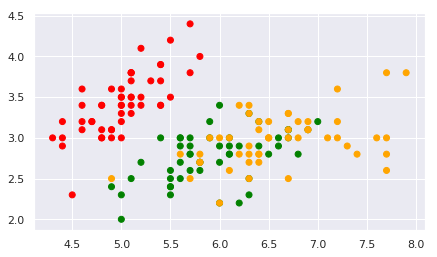

In [0]:
plt.figure(figsize = (7,4))
plt.scatter(data[:,0], data[:,1], cmap = my_cmap, c = labels)
plt.show()  # red ones can be linearly separated from others but it's complex to sparate other two. we need complex model for this.

In [0]:
print(data.shape, labels.shape)

(150, 2) (150,)


In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, random_state = 0, stratify = labels)
print(X_train.shape, Y_val)

(112, 2) [0 0 0 0 1 1 1 0 1 2 2 2 1 2 1 0 0 2 0 1 2 1 1 0 2 0 0 1 2 1 0 1 2 2 0 1 2
 2]


In [0]:
oh = OneHotEncoder()
Y_oh_train = oh.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_oh_val  = oh.fit_transform(np.expand_dims(Y_val, 1)).toarray()
print(Y_oh_train.shape, Y_oh_val.shape)

(112, 3) (38, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [0]:
class FFNNetwork:

  def __init__(self, activation_function = 'sigmoid', init_method = 'xavier', num_hidden = 2, leaky_slope = 0.1):

    self.params = {}
    self.activation_function = activation_function
    self.layer_size = [2, num_hidden, 3]
    self.num_layers = 2
    self.leaky_slope = leaky_slope
    np.random.seed(0)

    if init_method == 'random':
      for i in range(1,self.num_layers+1):
        self.params['W'+str(i)] = np.random.randn(self.layer_size[i-1], self.layer_size[i])
        self.params['B'+str(i)] = np.random.randn(1, self.layer_size[i])
    
    if init_method == 'xavier':
      for i in range(1, self.num_layers+1):
        self.params['W'+str(i)] = np.random.randn(self.layer_size[i-1], self.layer_size[i])*np.sqrt(1/self.layer_size[i-1])
        self.params['B'+str(i)] = np.random.randn(1, self.layer_size[i])
    
    if init_method == 'he':
      for i in range(1, self.num_layers+1):
        self.params['W'+str(i)] = np.random.randn(self.layer_size[i-1], self.layer_size[i])*np.sqrt(2/self.layer_size[i-1])
        self.params['B'+str(i)] = np.random.randn(1, self.layer_size[i])

    self.update_params = {}
    self.prev_update_params = {}
    self.gradients = {}
    for i in range(1, self.num_layers+1):
      self.update_params['v_w'+str(i)] = 0
      self.update_params['v_b'+str(i)] = 0
      self.update_params['m_w'+str(i)] = 0
      self.update_params['m_b'+str(i)] = 0
      self.prev_update_params['v_w'+str(i)] = 0
      self.prev_update_params['v_b'+str(i)] = 0

  def forward_activation(self, X):
    if self.activation_function == 'sigmoid':
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == 'tanh':
      return np.tanh(X)
    elif self.activation_function == 'relu':
      return np.maximum(0, X)
    elif self.activation_function == 'leaky_relu':
      return np.maximum(self.leaky_slope*X, X)
  
  def grad_activation(self, X):
    if self.activation_function == 'sigmoid':
      return X * (1 - X)
    elif self.activation_function == 'relu':
      return 1.0 * (X>0)
    elif self.activation_function == 'tanh':
      return 1 - np.square(X)
    elif self.activation_function == 'leaky_relu':
      d = np.zeros_like(X)
      d[X>0] = 1
      d[x<=0] = self.leaky_slope
      return d

  def SoftMax(self, X):
    exps = np.exp(X)
    return exps/np.sum(exps, axis = 1).reshape(-1, 1)
  
  def forward_pass(self, X, params = None):
    if params is None:
      params = self.params
    self.A1 = np.matmul(X, params['W1']) + params['B1']
    self.H1 = self.forward_activation(self.A1)
    self.A2 = np.matmul(self.H1, params['W2']) + params['B2']
    self.H2 = self.SoftMax(self.A2)  # (N,2) size
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)

  def accuracy(self, X, X_val):
    Y_pred_train = self.predict(X)
    Y_pred_train = np.argmax(Y_pred_train, 1)
    Y_pred_val = self.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val, 1)
    train_acc = accuracy_score(Y_pred_train, Y_train)
    val_acc = accuracy_score(Y_pred_val, Y_val)
    return train_acc, val_acc
  
  def fit(self, X, X_val, Y, epochs = 10, lr = 1, algo= "GD", l2_norm=False, lambda_val=0.8, display_loss=False):
    train_accuracies = {}
    val_accuracies = {}      # validation accuracy dictionary
    if display_loss:
      loss = {}
      weight_mag = []
    for i in tqdm_notebook(range(epochs), total = epochs, unit = 'epochs'):
      
      m = X.shape[0]
      self.grad(X, Y)
      for j in range(1, self.num_layers+1):
        if l2_norm:
          self.params["W"+str(j)] -= (lr * lambda_val)/m * self.params["W"+str(j)] + lr * (self.gradients["dW"+str(j)]/m)
        else:
          self.params['W'+str(j)] -= lr * (self.gradients['dW'+str(j)]/m)
        self.params['B'+str(j)] -= lr* (self.gradients['dB'+str(j)]/m)
      
      train_accuracy, val_accuracy = self.accuracy(X, X_val)
      train_accuracies[i] = train_accuracy
      val_accuracies[i] = val_accuracy       # validation accuracy
      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis = 1), Y_pred)
        weight_mag.append((norm(self.params['W1']) + norm(self.params['W2']) + norm(self.params['B1']) + norm(self.params['B2']))/18)

    plt.figure(figsize = (7,5))
    plt.plot(train_accuracies.values(), label = 'Training Accuracy')
    plt.plot(val_accuracies.values(), label = 'Validation Accuracy')
    plt.plot(np.ones((epochs, 1))*0.33)   # a baseline set as 33% is the most obvious accuracy to achieve in this dataset
    plt.plot(np.ones((epochs, 1))*0.9)  # 90% accuracy is just another baseline set
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 

    if display_loss:
      plt.figure(figsize = (8,5))
      fig, ax1 = plt.subplots()
      color = 'tab:red'
      ax1.set_xlabel('Epochs')
      ax1.set_ylabel('Loss', color = color)
      ax1.plot(loss.values(), '-o', color = color)
      ax1.tick_params(axis = 'y', labelcolor = color)  # used to give color to axis parameters
      ax2 = ax1.twinx()      # creates a subplot with same x axis & different y - axis
      color = 'tab:blue'
      ax2.set_ylabel('Weight-Magnitude')
      ax2.tick_params(axis = 'y', labelcolor = color)
      ax2.plot(weight_mag, '-*', color = color)
      fig.tight_layout()
      plt.show()

  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()


In [0]:
def print_accuracy():
  Y_pred_train = ffn.predict(X_train)
  Y_pred_train = np.argmax(Y_pred_train, axis = 1)
  Y_pred_val = ffn.predict(X_val)
  Y_pred_val = np.argmax(Y_pred_val, axis = 1)
  print('Training Accuracy:',accuracy_score(Y_pred_train, Y_train))
  print('Validation Accuracy:',accuracy_score(Y_pred_val, Y_val))

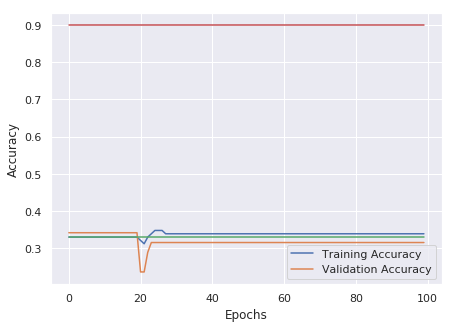

Training Accuracy: 0.3392857142857143
Validation Accuracy: 0.3157894736842105


In [0]:
ffn = FFNNetwork()
ffn.fit(X_train, X_val, Y_oh_train, epochs = 100, lr = 0.1)
print_accuracy()

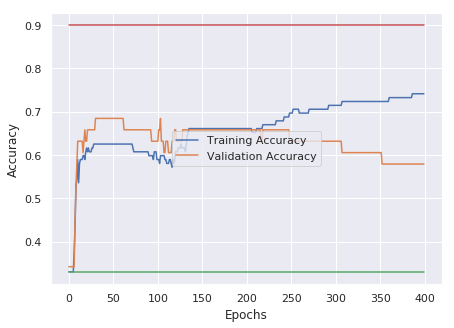

Training Accuracy: 0.7410714285714286
Validation Accuracy: 0.5789473684210527


In [0]:
ffn = FFNNetwork(num_hidden = 4)
ffn.fit(X_train, X_val, Y_oh_train, epochs = 400, lr = 0.25,display_loss=False)
print_accuracy()

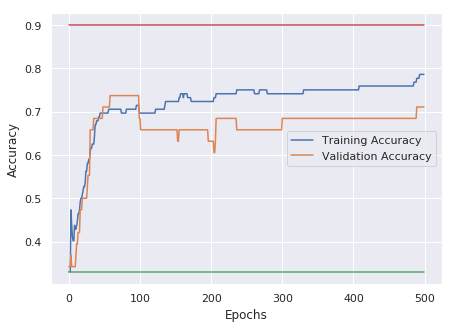

Training Accuracy: 0.7857142857142857
Validation Accuracy: 0.7105263157894737


In [0]:
ffn = FFNNetwork(num_hidden=8)
ffn.fit(X_train, X_val, Y_oh_train, epochs = 500, lr = 0.2)
print_accuracy()

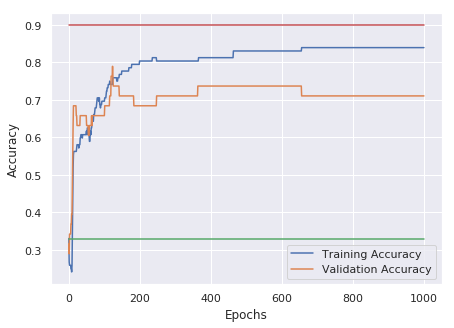

Training Accuracy: 0.8392857142857143
Validation Accuracy: 0.7105263157894737


In [0]:
ffn = FFNNetwork(num_hidden = 32)
ffn.fit(X_train, X_val, Y_oh_train, epochs = 1000, lr = 0.2)
print_accuracy()

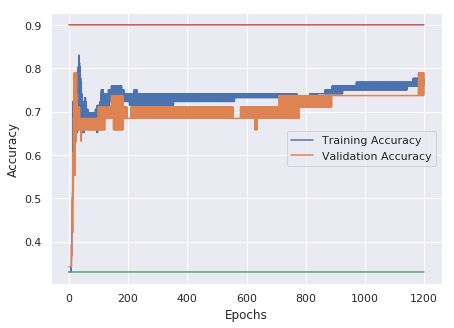

Training Accuracy: 0.7767857142857143
Validation Accuracy: 0.7894736842105263


In [0]:
ffn = FFNNetwork(num_hidden = 64)
ffn.fit(X_train, X_val, Y_oh_train, epochs = 1200, lr = 0.2)
print_accuracy()

#L2 Regularization

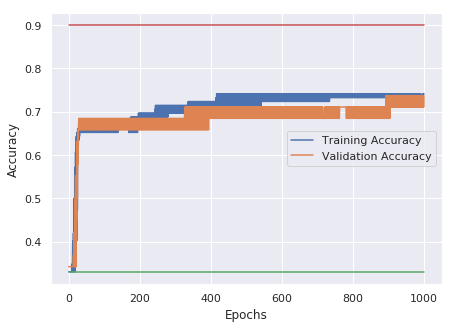

<Figure size 576x360 with 0 Axes>

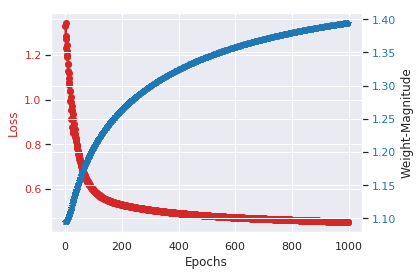

Training Accuracy: 0.7410714285714286
Validation Accuracy: 0.7105263157894737


In [0]:
ffn = FFNNetwork(num_hidden = 64)
ffn.fit(X_train, X_val, Y_oh_train, epochs = 1000, lr = 0.25, lambda_val = 0.1, l2_norm=True, display_loss=True)
print_accuracy()

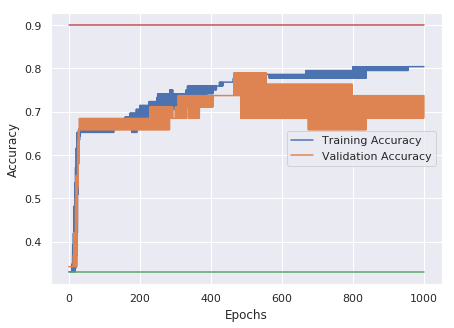

<Figure size 576x360 with 0 Axes>

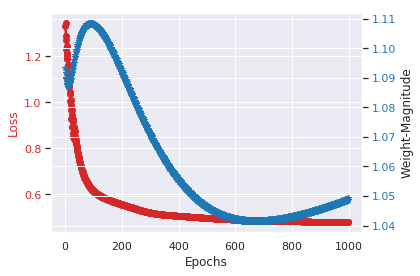

Training Accuracy: 0.8035714285714286
Validation Accuracy: 0.7368421052631579


In [0]:
ffn = FFNNetwork(num_hidden=64)
ffn.fit(X_train, X_val, Y_oh_train, epochs = 1000, lr = 0.25, l2_norm=True, lambda_val=1, display_loss=True)
print_accuracy()  # bias decreased in this case but variance increased. bias is gap b/w red & blue line. variancei s difference in train & validation accuracy

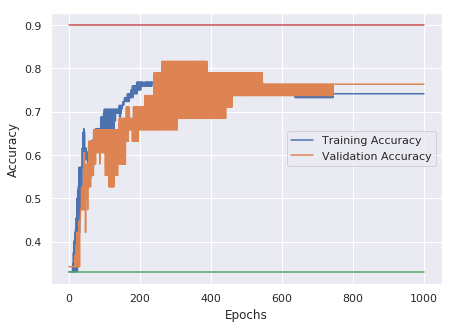

<Figure size 576x360 with 0 Axes>

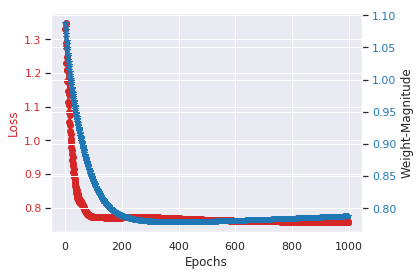

Training Accuracy: 0.7410714285714286
Validation Accuracy: 0.7631578947368421


In [0]:
ffn = FFNNetwork(num_hidden=64)
ffn.fit(X_train, X_val, Y_oh_train, epochs = 1000, lr = 0.25, l2_norm = True, lambda_val=5, display_loss=True)
print_accuracy()  # variance decreased, bias increased. they both keep varying. we have to find the most stable, accurate condition

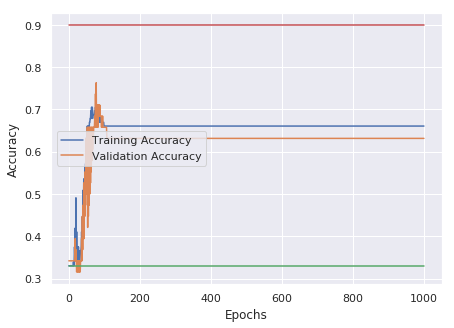

<Figure size 576x360 with 0 Axes>

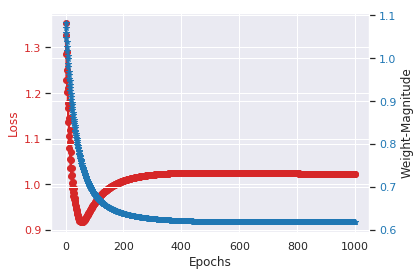

Training Accuracy: 0.6607142857142857
Validation Accuracy: 0.631578947368421


In [0]:
ffn = FFNNetwork(num_hidden=64)
ffn.fit(X_train, X_val, Y_oh_train, epochs = 1000, lr = 0.25, l2_norm=True, lambda_val=10, display_loss=True)
print_accuracy()

#Adding noice to trainig data

0.01


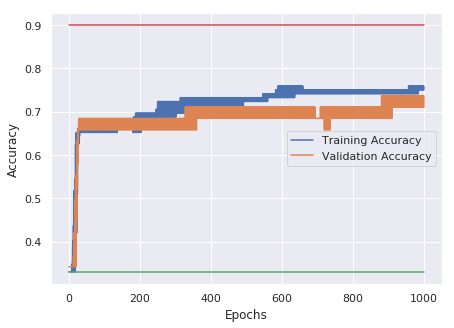

Training Accuracy: 0.7321428571428571
Validation Accuracy: 0.7105263157894737
0.05


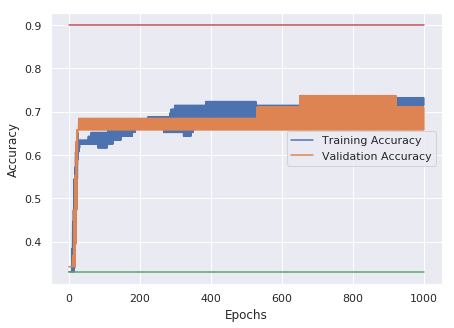

Training Accuracy: 0.6964285714285714
Validation Accuracy: 0.6578947368421053
0.1


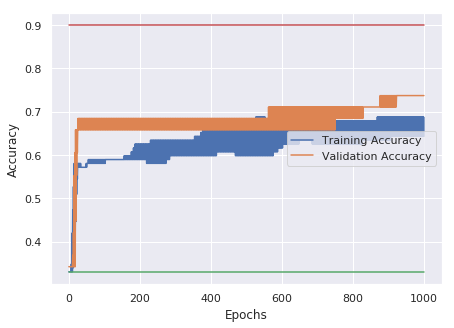

Training Accuracy: 0.7142857142857143
Validation Accuracy: 0.7368421052631579
0.15


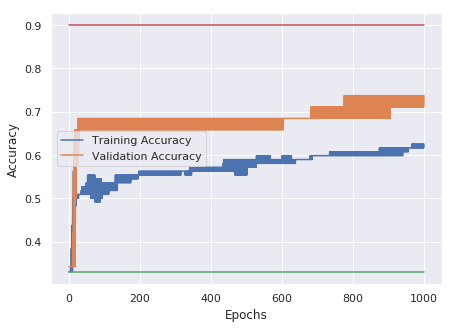

Training Accuracy: 0.7232142857142857
Validation Accuracy: 0.7368421052631579
0.2


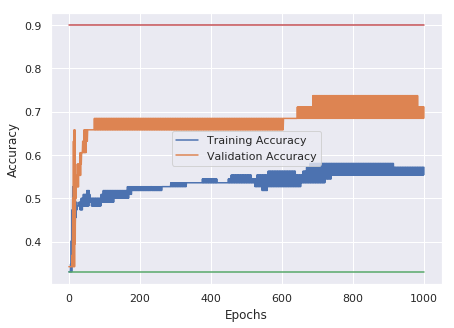

Training Accuracy: 0.7321428571428571
Validation Accuracy: 0.7105263157894737


In [0]:
noise_fraction = [0.01, 0.05, 0.1, 0.15, 0.2]
for noise in noise_fraction:
  print(noise)
  X_train_noisy = X_train * (1 - noise * np.random.randn(X_train.shape[0], X_train.shape[1]))
  ffn = FFNNetwork(num_hidden = 64)
  ffn.fit(X_train_noisy, X_val, Y_oh_train, epochs = 1000, lr = 0.25)
  print_accuracy()
  print('==========')